In [4]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import pydicom
from pydicom.data import get_testdata_file
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [6]:
test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [8]:
os.listdir('/kaggle/input/rsna-breast-cancer-detection/train_images')[:10]

['10706',
 '21867',
 '34867',
 '49211',
 '5550',
 '47903',
 '11840',
 '46113',
 '43851',
 '63745']

In [9]:
patient_id = '21867'

os.listdir(f'/kaggle/input/rsna-breast-cancer-detection/train_images/{patient_id}')

['1291014447.dcm', '831671840.dcm', '1481837831.dcm', '851000290.dcm']

In [10]:
idx = 5

base_img_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images'

img_id = str(train_df['image_id'].iloc[idx])
full_img_id = img_id + '.dcm'
pat_id = str(train_df['patient_id'].iloc[idx])

label = train_df['cancer'].iloc[idx]

os.path.join(base_img_dir, pat_id, full_img_id)

'/kaggle/input/rsna-breast-cancer-detection/train_images/10011/270344397.dcm'

In [12]:
img_path = os.path.join(base_img_dir, pat_id, full_img_id)
img_path

'/kaggle/input/rsna-breast-cancer-detection/train_images/10011/270344397.dcm'

## Reading the image from the path and converting to tensor

In [13]:
dcm_img = pydicom.dcmread(img_path, force = True)
dcm_img

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10011.1.270344397
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10011.1.270344397
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183903.261543'
(0010, 0020) Patient ID                          LO: '10011'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10011
(0020, 000e) Series Instance U

In [14]:
img_array = dcm_img.pixel_array
img_array

array([[3036, 3001, 2750, ...,    0,    0,    0],
       [2716, 2862, 3058, ...,    0,    0,    0],
       [2758, 2837, 2543, ...,    0,    0,    0],
       ...,
       [1670, 1666, 1674, ...,    0,    0,    0],
       [1867, 1658, 1760, ...,    0,    0,    0],
       [1776, 1822, 1690, ...,    0,    0,    0]], dtype=uint16)

Text(0.5, 1.0, "Patient 10011 doesn't have cancer in image: 270344397")

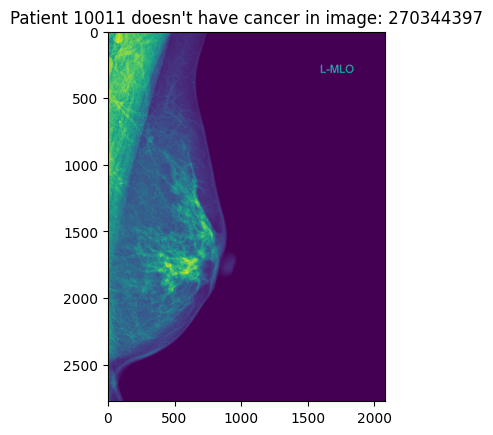

In [16]:
plt.imshow(img_array)
if label == 0:
    category = "doesn't have cancer"
elif label == 1:
    category = "has cancer"
    
plt.title(f'Patient {pat_id} {category} in image: {img_id}')

In [63]:
# no cancer
def random_no_cancer_img_sample(
    df: pd.DataFrame,
    random_state: int = 42,
    base_img_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images'):
    
    df_label_0 = df[df['cancer'] == 0]
    
    df_sample_label_0 = df_label_0.sample(9, random_state=random_state).reset_index()
    
    fix, ax = plt.subplots(3, 3, figsize=(14, 14))
    
    for idx_num, row in df_sample_label_0.iterrows():
        img_id = str(row['image_id'])
        full_img_id = img_id + '.dcm'
        pat_id = str(row['patient_id'])
        
        label = row['cancer']
        
        img_path = os.path.join(base_img_dir, pat_id, full_img_id)
        q, r = divmod(idx_num, 3)
        
        img_array = pydicom.dcmread(img_path, force=True).pixel_array
        
        ax[q][r].imshow(img_array)
        ax[q][r].set_title(f'Image label: {label}')


In [65]:
# cancer
def random_cancer_img_sample(
    df: pd.DataFrame,
    random_state: int = 42,
    base_img_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images'):
    
    df_label_1 = df[df['cancer'] == 1]
    
    df_sample_label_1 = df_label_1.sample(9, random_state=random_state).reset_index()
    
    fix, ax = plt.subplots(3, 3, figsize=(14, 14))
    
    for idx_num, row in df_sample_label_1.iterrows():
        img_id = str(row['image_id'])
        full_img_id = img_id + '.dcm'
        pat_id = str(row['patient_id'])
        
        label = row['cancer']
        
        img_path = os.path.join(base_img_dir, pat_id, full_img_id)
        q, r = divmod(idx_num, 3)
        
        img_array = pydicom.dcmread(img_path, force=True).pixel_array
        
        ax[q][r].imshow(img_array)
        ax[q][r].set_title(f'Image label: {label}')


### No cancer

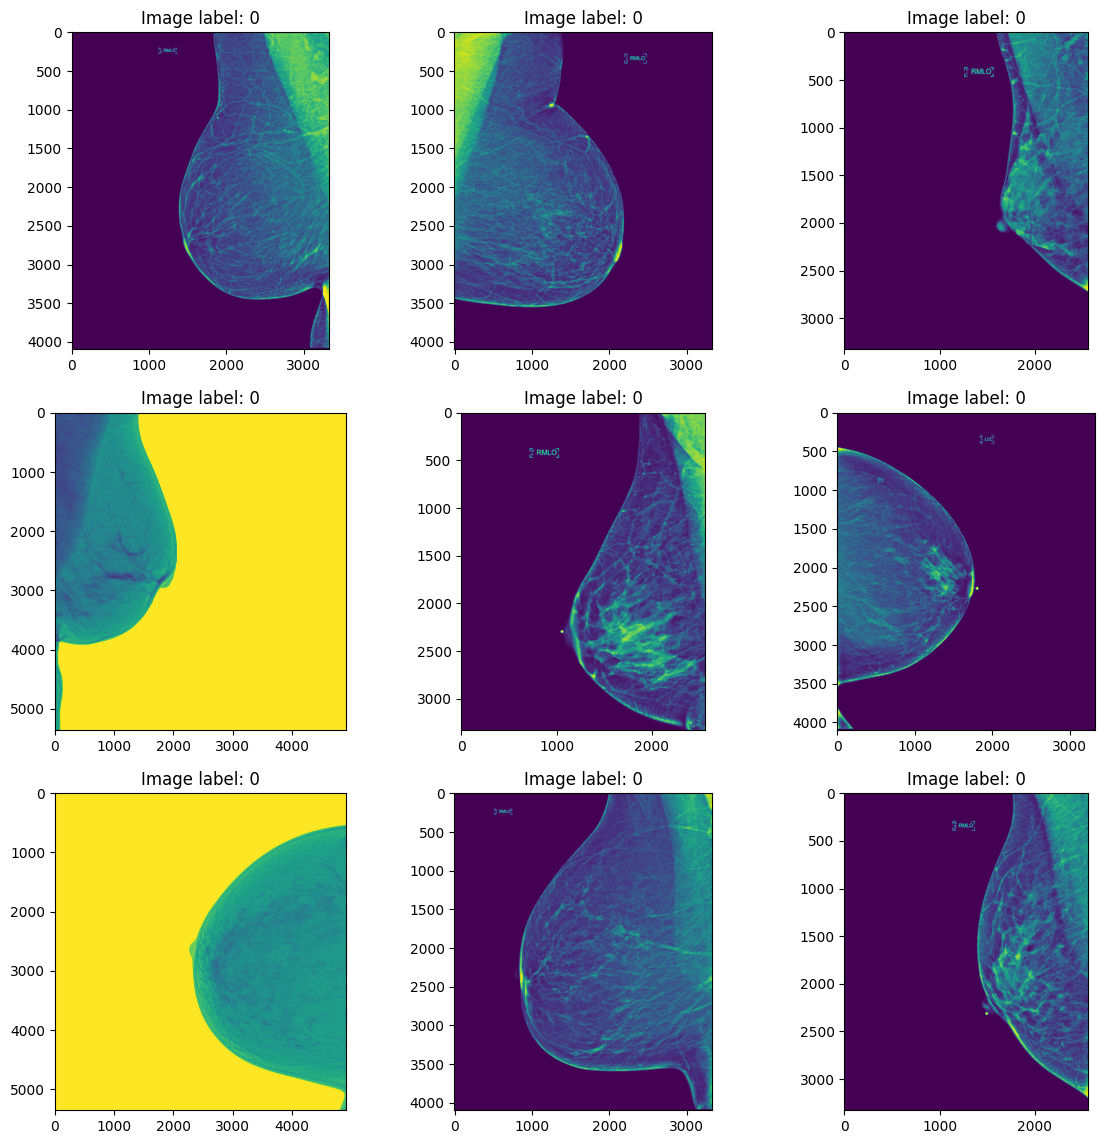

In [64]:
random_no_cancer_img_sample(train_df)

### Cancer

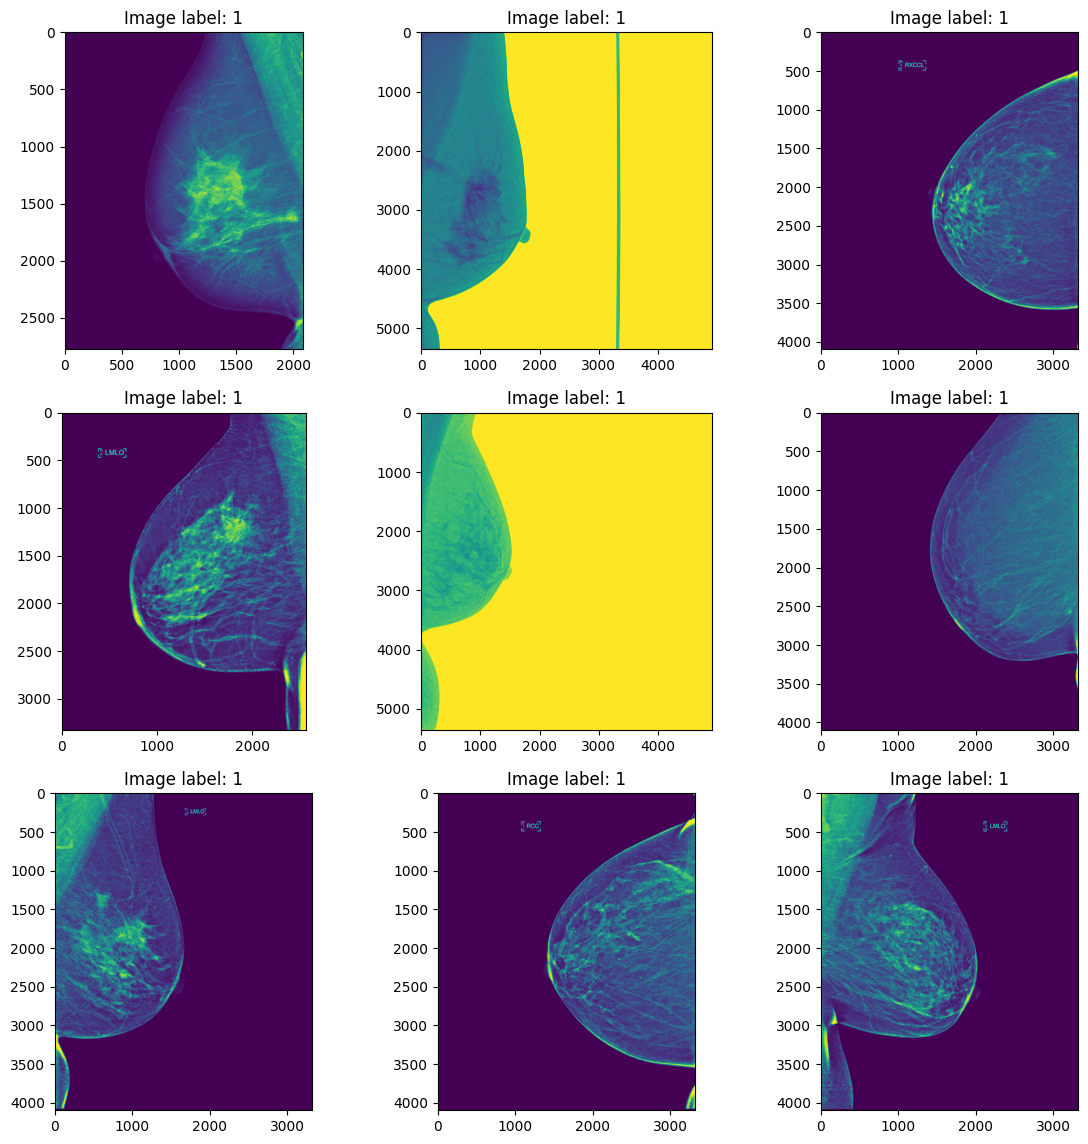

In [66]:
random_cancer_img_sample(train_df)